<a href="https://colab.research.google.com/github/uu-sml/wasp-assigninmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Martin Funkquist, Dominik Drexler</font>

- **Team ID:** <font color='red'>RLPLab_Lkpg</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health. 
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam. 


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks. 

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long. 

In [19]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [1]:
# Import
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels. 
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [ ]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

In [ ]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [ ]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

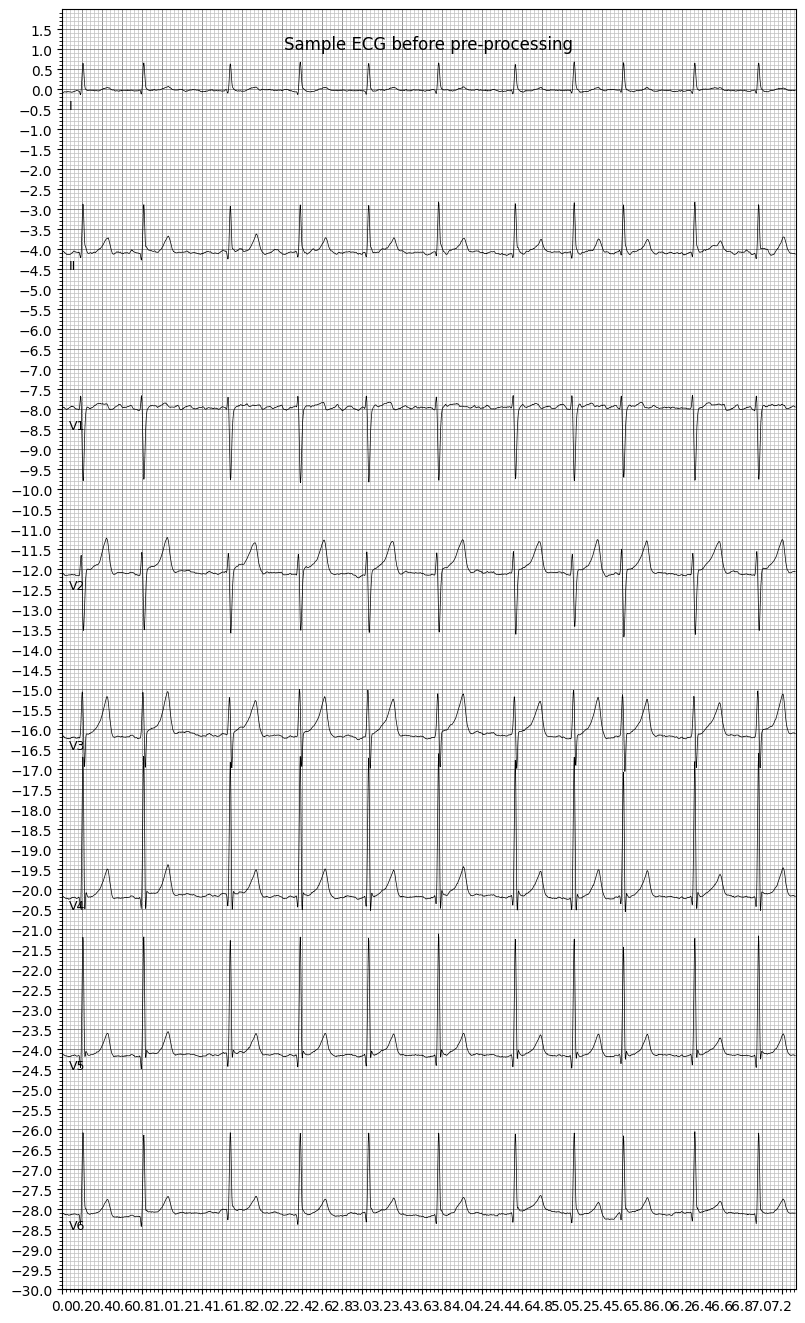

In [24]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

In [ ]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8. 
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [ ]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


In [25]:
"""
TASK: Insert your code here
"""
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
print(f)
data = f['tracings']

data

<HDF5 file "train.h5" (mode r)>


<HDF5 dataset "tracings": shape (10000, 4096, 8), type "<f8">

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

- The preprocessing makes all the ECG samples the same length, which is needed for the input to a Convolutional Neural Network as the architecture requires a fixed input size
- When the ECG samples all have the same length, these can be stacked into a batch
- The preprocessing normalizes some of the noise

---
## Model

The model class consists of two methods: 
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations: 
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# HYPERPARAMETERS
weight_decay = 1e-1  
num_epochs = 50

learning_rate = 1e-4 
batch_size = 32
dropout = 0.0
nr_res_blocks = 4
kernel_size = 63
factor = 8
out_channels = 8

config = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "dropout_rate": dropout,
    "n_res_blks": nr_res_blocks,
    "kernel_size": kernel_size,
    "factor": factor,
    "out_channels": out_channels
}

debug = False

In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 128

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [ ]:
import torch
from torch import nn


class ResBlk(nn.Module):
    def __init__(self, kernel_size: int, dropout_rate: float, in_channels: int, out_channels: int, factor: int):
        assert kernel_size % 2 == 1  # kernel_size must be odd
        super(ResBlk, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same", bias=False)
        self.batchnorm1 = nn.BatchNorm1d(out_channels, track_running_stats=False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=factor, padding=padding, bias=False)

        self.max_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=factor, padding=padding)
        self.conv11 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding="same", bias=False)

    def forward(self, x):
        assert len(x.shape) == 4 and x.shape[0] == 2
        x1 = x[0, :, :, :]
        x2 = x[1, :, :, :]

        assert len(x1.shape) == 3 and len(x2.shape) == 3

        x1 = self.max_pool(x1)
        x1 = self.conv11(x1)

        x2 = self.conv1(x2)
        x2 = self.batchnorm1(x2)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        x2 = self.conv2(x2)

        assert x1.shape == x2.shape

        x = x1 + x2

        assert len(x.shape) == 3

        x1 = x

        x2 = x
        x2 = self.batchnorm1(x)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)

        x = torch.stack([x1, x2], dim=0)
        return x


class Model(nn.Module):
    def __init__(self, kernel_size: int, n_res_blks: int, dropout_rate: float, out_channels: int, factor: int):
        super(Model, self).__init__()
        self.conv = nn.Conv1d(in_channels=8, out_channels=out_channels, kernel_size=kernel_size, padding="same", bias=False)
        self.batchnorm = nn.BatchNorm1d(num_features=out_channels, track_running_stats=False)
        self.relu = nn.ReLU()

        self.res_layers = nn.Sequential()
        tmp_out_channels = out_channels
        out_sequence_length = 4096
        for i in range(n_res_blks):
            in_channels = out_channels + (i // 2) * out_channels
            tmp_out_channels = out_channels + ((i+1) // 2) * out_channels
            self.res_layers.append(
                ResBlk(
                    kernel_size=kernel_size,
                    dropout_rate=dropout_rate,
                    in_channels=in_channels,
                    out_channels=tmp_out_channels,
                    factor=factor)
            )
            out_sequence_length //= factor

        self.linear = torch.nn.Linear(tmp_out_channels*out_sequence_length, 1, bias=False)


    def forward(self, x):
        # Preprocessing
        #assert len(x.shape) == 3 and x.shape[1] == 4096 and x.shape[2] == 8
        x = x.transpose(2,1)
        #assert len(x.shape) == 3 and x.shape[1] == 8 and x.shape[2] == 4096

        # Block 1:
        x = self.conv(x)
        #assert len(x.shape) == 3 and x.shape[1] == 64 and x.shape[2] == 4096
        x = self.batchnorm(x)
        x = self.relu(x)

        # Block 2: ResBlks
        x = torch.stack([x, x], dim=0)
        x = self.res_layers(x)
        x = x[1]
        # need to flatten last two dimensions => 32 x 192*4096
        x = x.view(x.size(0), -1)

        # Block 3:
        x = self.linear(x)

        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**

- We think that a CNN is a good choice because the signal repeats after a certain amount of time. Therefore taking into consideration the local information of one cycle probably gives good low level features that are combined to higher level features in deeper convolutional layers of the network that consider several cycles. When doing literature study, we noticed that this is often done and we decided to follow the approach of using ResNets which additionally use skip connections, batch normalization, and dropout to improve the learning.
- We used hyperparameter optimization to obtain good hyperparameters for the filter size and depth of the network.

---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [ ]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    train_pred, train_true = [], []
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses_cpu in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses_cpu.to(device)

        optimizer.zero_grad()
        output = model(traces)
        loss = loss_function(output, diagnoses)
        loss.backward()
        optimizer.step()

        pred_classes = (nn.Sigmoid()(output) > 0.5).float().cpu()
        train_pred.append(pred_classes)
        train_true.append(diagnoses_cpu)

        # Update accumulated values
        total_loss += loss.item()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})

        if debug: break

    train_pbar.close()
    return total_loss / n_entries, np.vstack(train_pred), np.vstack(train_true)

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [ ]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    with torch.no_grad():
        for traces_cpu, diagnoses_cpu in eval_pbar:
            # data to device (CPU or GPU if available)
            traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

            output = model(traces)
            loss = loss_function(output, diagnoses)
            pred_classes = (nn.Sigmoid()(output) > 0.5).float().cpu()
            valid_pred.append(pred_classes)
            valid_true.append(diagnoses_cpu)

            # Update accumulated values
            total_loss += loss.item()
            n_entries += len(traces)

            # Update progress bar
            eval_pbar.set_postfix({'loss': total_loss / n_entries})

            if debug: break

    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**

- Since choosing hyperparameters by hand is very time consuming, it is standard practice to use a hyperparameterization tool. We decided to use SMAC3 () because it has a well documented python api and works in parallel. Our configuration space consisted of 10800 configurations from which we allowed to sample up to 500 configurations with 1 day wallclock timeout. Each configuration consisted of the learning rate $\in\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1} \}$, kernel size $\in\{7, 15, 31, 63\}$, number of residual blocks $\{1, 2, 3, 4\}$, dropout rate $\in\{0.0, 0.5, 0.8\}$, batch size $\in\{16, 32, 64\}$, output channels $\in\{8, 16, 32, 64, 128\}$, subsampling factor $\in\{2, 4, 8\}$.

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
generator = torch.Generator().manual_seed(seed)
dataset_train, dataset_valid = random_split(dataset, [0.8, 0.2], generator)

# build data loaders
if debug:
    train_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
else:
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
# model = ModelBaseline()
model = Model(kernel_size=config["kernel_size"], n_res_blks=config["n_res_blks"], dropout_rate=config["dropout_rate"], out_channels=config["out_channels"], factor=config["factor"])

model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = torch.nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all, train_auroc_all, valid_auroc_all = [], [], [], []

num_epochs = 200
# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss, y_train_pred, y_train_true = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_valid_pred, y_valid_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """    
    # Apply the sigmoid activation to get the probabilities from logits
    # print("y_train_pred:", torch.tensor(y_train_pred))
    # print("y_valid_pred:", torch.tensor(y_valid_pred))

    # Flatten the probabilities and true labels for AUROC calculation
    train_pred_flat = y_train_pred.flatten()
    valid_pred_flat = y_valid_pred.flatten()   
    train_true_flat = y_train_true.flatten()
    valid_true_flat = y_valid_true.flatten() 

    # print("train_true_flat:", train_true_flat)
    # print("valid_true_flat:", valid_true_flat)

    # Calculate AUROC
    train_auroc = roc_auc_score(train_true_flat, train_pred_flat)
    train_auroc_all.append(train_auroc)
    tqdm.write("Training AUROC: {:.4f}".format(train_auroc))

    valid_auroc = roc_auc_score(valid_true_flat, valid_pred_flat)
    valid_auroc_all.append(valid_auroc)
    tqdm.write("Validation AUROC: {:.4f}".format(valid_auroc))

    valid_ap = average_precision_score(valid_true_flat, valid_pred_flat)
    tqdm.write("Validation AP: {:.2f}".format(valid_ap))


    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.title("Train and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
train_x = range(len(train_loss_all))
train_y = train_loss_all
plt.plot(train_x, train_y, label="train_loss", color="blue")
valid_x = range(len(valid_loss_all))
valid_y = valid_loss_all
plt.plot(valid_x, valid_y, label="valid_loss", color="orange")
plt.legend()
plt.show()

plt.title("Area Under Curve (AUROC)")
plt.xlabel("epoch")
plt.ylabel("auroc")
train_auroc_x = range(len(train_auroc_all))
train_auroc_y = train_auroc_all
plt.plot(train_auroc_x, train_auroc_y, label="train_auroc", color="blue")
valid_auroc_x = range(len(valid_auroc_all))
valid_auroc_y = valid_auroc_all
plt.plot(valid_auroc_x, valid_auroc_y, label="valid_auroc", color="orange")
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities). 

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below). 

In [17]:
# Imports
from torch.utils.data import TensorDataset, random_split, DataLoader
from src.model import Model
import torch

# Hyperparams
batch_size = 32

ModuleNotFoundError: No module named 'model'

In [6]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [16]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
# model = ModelBaseline()

# load stored model parameters
model_file = "models/model3.pth"
model = torch.load(model_file, map_location=device)
# ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
# model.load_state_dict(ckpt['model'])
# put model on device
# model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...


ModuleNotFoundError: No module named 'model'

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [21]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Receiving objects: 100% (3/3), done.


In [22]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. 
Do not change this after you have registered your team
"""
team_id = 'rleap' #Fill in a string
password = 'password' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

Team registered successfully! Good luck


In [23]:
import json
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'Best Model' #Fill in a string

soft_pred = json.load(open("test_pred.json", "r"))

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
# r = submit(team_id, password, soft_pred.tolist(), note)
r = submit(team_id, password, soft_pred, note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

We only did one submission, but recieved the required scores

Your team id: **rleap**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|Best Model       | 0.921    | 0.916 | 0.973 | 0.968 | The top model from a SMAC hyperparameter search |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**

- The AUC is the area under the Receiver Operating Characteristic (ROC) curve. The ROC curve plots the True Positive Rate (TPR) e.g. recall on the y-axis and the False Positive Rate on the x-axis, at different classification thresholds. If it is important that when the model predicts a true label it is actually true (low FPR) then we have to make the tradeoff that the model will not be able to predict so many of the positive classes. In other words, we would set the threshold for predicting a positive label high e.g. the model only says that something is true when it is very confident that it is. If the AUC is high, the tradeoff is not so large. Ideally the AUC would be 1 and no tradeoff would be needed, as the model would predict all labels perfectly. 
- The AP is the area under the precision-recall curve. The precision-recall curve shows the trade-off in precision and recall for a specific model. It has the precision on the y-axis and the recall on the x-axis, each point representing a specific classification threshold. For the edge cases of predicting only true (100% recall, 0% precision) and predicting only false (0% recall, 100% precision) the graph may be easily understood. But anywhere between these, it depends on the model. In general, the larger the area the better the model and the less the tradeoff is that one has to make between the precision and recall. 
- If we only focus on AP we could get a unrealistically favorable opinition of our model in the case where it only predicts positive labels and the dataset is heavily skewed towards positive labels. For example if our test set contains 10 samples, 9 of them positive and 1 negative, then a model that only predicts positive labels would get a precision score P = 9 / 10 = 0.9 and a recall score R = 9 / 9 = 1, which would give a good AP score. But we know that this model is bad. By also introducing the AUC score, which would give us: TPR = 9 / 10 = 0.9 and FPR = 1 / 1 = 1 (WTF?). 
- If we only focus on AUC.... To use the AP metric can be good when we are working with **imbalanced classes** (why?). This is often the case in medical diagnoses when we are working with a rare disease e.g. there are much more negative labels than positive ones (thankfully). Just focusing on the accuracy in this case can make the model look better than it is. For example, if 99% of the labels are negative then a model that **only** predicts negative labels will have an accuracy of 99%, even though it is a bad model. On the other hand, the precision of this model would be 0 (since true positives = 0) and the recall would also be 0 (for the same reason). 